# NLP Project
### Goal: Create a model that best predicts programming languages of Github repositories 

### Plan 

Scrape Github repositories to exaluate the README sections and build a model that will predict which programming language is used. 
- 100 repositories used 
- 10 different models

#### **Data Dictionary**

   - **Language:** Programming language used for repositort project

   - **README Content:** Description of each repository containing keywords used to make predictions

   - **Normalized:** README content normalized removing any uppercased characters, special characters, non-alpha characters, and alpha strings with 2 or less characters

   - **Stemmed:** README content reducing each word to its (psuedo)root 

   - **Lemmatized:** README content reducing each word to liguistically valid lemmas

   - **Cleaned:** README content that has been stemmed and then removes any stopwords 

### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

from requests import get
from bs4 import BeautifulSoup
import os
import json
import re
import unicodedata

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# matplotlib default plotting styles
plt.rc("patch", edgecolor="black", force_edgecolor=True)
plt.rc("axes", grid=True)
plt.rc("grid", linestyle=":", linewidth=0.8, alpha=0.7)
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", figsize=(11, 8))
plt.rc("font", size=12.0)
plt.rc("hist", bins=25)
from wordcloud import WordCloud

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier


import acquire
import prepare
from env import github_token

### Acquire

In [2]:
# Using our acquire.py file, we scraped URL's from Github to create a Corpus of data
#acquire.scrape_github_data()

In [3]:
original_df = pd.read_json('data.json')

In [4]:
original_df.head()

,language,readme_contents,repo
0,Python,# AIDungeon2\n\n### The model for AI Dungeon2 ...,AIDungeon/AIDungeon
1,Go,"[<img src=""https://rclone.org/img/logo_on_ligh...",rclone/rclone
2,Python,# PythonPlantsVsZombies\na simple PlantsVsZomb...,marblexu/PythonPlantsVsZombies
3,Rust,"<img alt=""OrbTk"" width=""380"" src=""https://gitl...",redox-os/orbtk
4,C,# UAC Bypass In The Wild\nWindows 10 UAC bypas...,sailay1996/UAC_Bypass_In_The_Wild


In [5]:
original_df.shape

(107, 3)

In [6]:
# We can see that there are 7 null values in the language column
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 3 columns):
language           100 non-null object
readme_contents    107 non-null object
repo               107 non-null object
dtypes: object(3)
memory usage: 2.6+ KB


In [7]:
original_df.language.value_counts()

JavaScript          25
Python              20
Ruby                 9
CSS                  9
Go                   7
Java                 5
HTML                 5
C++                  4
TypeScript           4
Jupyter Notebook     2
C                    2
PHP                  2
Kotlin               1
Rust                 1
CoffeeScript         1
Haskell              1
Clojure              1
C#                   1
Name: language, dtype: int64

In [8]:
# Drop any columns that do not have a language
original_df = original_df.dropna()

In [9]:
original_df.shape

(100, 3)

In [10]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 106
Data columns (total 3 columns):
language           100 non-null object
readme_contents    100 non-null object
repo               100 non-null object
dtypes: object(3)
memory usage: 3.1+ KB


### Prepare

In [11]:
# Make a copy of the original data frame we brought in dropping the repo column
df = original_df[['language', 'readme_contents']]

In [12]:
df.head()

,language,readme_contents
0,Python,# AIDungeon2\n\n### The model for AI Dungeon2 ...
1,Go,"[<img src=""https://rclone.org/img/logo_on_ligh..."
2,Python,# PythonPlantsVsZombies\na simple PlantsVsZomb...
3,Rust,"<img alt=""OrbTk"" width=""380"" src=""https://gitl..."
4,C,# UAC Bypass In The Wild\nWindows 10 UAC bypas...


In [13]:
df = prepare.prep_contents(df)

In [14]:
# Using a function from our prepare.py file, we created a new df displaying new columns using different methods to clean up the data
df.head()

,language,readme_contents,original,normalized,stemmed,lemmatized,cleaned
0,Python,# AIDungeon2\n\n### The model for AI Dungeon2 ...,# AIDungeon2\n\n### The model for AI Dungeon2 ...,aidungeon the model for dungeon tempo...,aidungeon the model for dungeon temporarili un...,aidungeon the model for dungeon temporarily un...,aidungeon model dungeon temporarily unavailabl...
1,Go,"[<img src=""https://rclone.org/img/logo_on_ligh...","[<img src=""https://rclone.org/img/logo_on_ligh...",img src https rclone org img logo light h...,img src http rclone org img logo light horizon...,img src http rclone org img logo light horizon...,img src org img logo light horizontal color sv...
2,Python,# PythonPlantsVsZombies\na simple PlantsVsZomb...,# PythonPlantsVsZombies\na simple PlantsVsZomb...,pythonplantsvszombies simple plantsvszombies ...,pythonplantsvszombi simpl plantsvszombi game i...,pythonplantsvszombies simple plantsvszombies g...,pythonplantsvszombies simple plantsvszombies g...
3,Rust,"<img alt=""OrbTk"" width=""380"" src=""https://gitl...","<img alt=""OrbTk"" width=""380"" src=""https://gitl...",img alt orbtk width src https gitla...,img alt orbtk width src http gitlab redox org ...,img alt orbtk width src http gitlab redox org ...,img alt width src gitlab redox org redox asset...
4,C,# UAC Bypass In The Wild\nWindows 10 UAC bypas...,# UAC Bypass In The Wild\nWindows 10 UAC bypas...,uac bypass the wild windows uac bypass for...,uac bypass the wild window uac bypass for all ...,uac bypass the wild window uac bypass for all ...,uac bypass wild window uac bypass executable f...


In [15]:
# Since we created a new column titled 'original', we will drop readme_contents column
df = df.drop(columns='readme_contents')

In [16]:
df.head(2)

,language,original,normalized,stemmed,lemmatized,cleaned
0,Python,# AIDungeon2\n\n### The model for AI Dungeon2 ...,aidungeon the model for dungeon tempo...,aidungeon the model for dungeon temporarili un...,aidungeon the model for dungeon temporarily un...,aidungeon model dungeon temporarily unavailabl...
1,Go,"[<img src=""https://rclone.org/img/logo_on_ligh...",img src https rclone org img logo light h...,img src http rclone org img logo light horizon...,img src http rclone org img logo light horizon...,img src org img logo light horizontal color sv...


In [17]:
# Look at the contents using the cleaned column to assure it is cleaned up as we want it to be
df.cleaned[0]

'aidungeon model dungeon temporarily unavailable download due cost working solution read aidungeon wa built pcc byu edu dungeon creating infinitely generated text adventure deep learning language model play game colab aidungeon play game locally recommended nvidia gpu memory cuda installed gpu turn take couple minute game compose response install play locally git clone aidungeon aidungeon aidungeon install python play community aidungeon open source project question discussion contribution welcome contribution anything new package bugfixes documentation even new core feature resource website aidungeon aidungeon aidungeon twitter creator nickwalton twitter nickwalton dev benjbay twitter benjbay reddit aidungeon reddit aidungeon discord aidungeon discord discord vcz contributing contributing aidungeon relatively easy send pull request help article using pull request fork send request make develop destination branch aidungeon repository nickwalton aidungeon prefer pr pep python org dev pe

In [18]:
# We will run several models using different cleaning methods

### Explore

In [19]:
df.language.value_counts()

JavaScript          25
Python              20
Ruby                 9
CSS                  9
Go                   7
Java                 5
HTML                 5
C++                  4
TypeScript           4
Jupyter Notebook     2
C                    2
PHP                  2
Kotlin               1
Rust                 1
CoffeeScript         1
Haskell              1
Clojure              1
C#                   1
Name: language, dtype: int64

In [20]:
# We created a new df to display the number of times a language appears abd the percentages that each programming language is featured in our corpus
percents = pd.concat(
    [df.language.value_counts(), df.language.value_counts(normalize=True)], axis=1
).set_axis(["n", "percent"], axis=1, inplace=False)
percents

,n,percent
JavaScript,25,0.25
Python,20,0.20
Ruby,9,0.09
CSS,9,0.09
Go,7,0.07
Java,5,0.05
HTML,5,0.05
C++,4,0.04
TypeScript,4,0.04
Jupyter Notebook,2,0.02


In [21]:
# Moving forward with the cleaned column from out df, we will create a new series splitting the words
raw_count = pd.Series(" ".join(df.cleaned).split()).value_counts()
raw_count

org                              634
img                              558
file                             514
src                              489
svg                              470
html                             394
code                             384
use                              364
doc                              354
href                             324
master                           316
project                          315
license                          301
cs                               292
plugin                           275
badge                            274
build                            269
using                            254
run                              249
line                             230
install                          230
png                              217
image                            211
python                           208
release                          205
version                          204
opencollective                   197
e

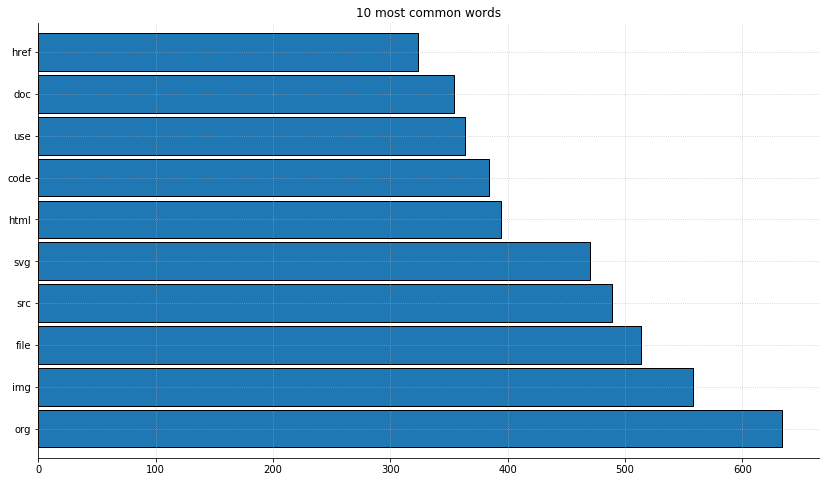

In [22]:
plt.figure(figsize=(14,8))
raw_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('10 most common words')
plt.show()

In [23]:
tf_df = pd.DataFrame({'raw_count': raw_count})

tf_df = tf_df.assign(frequency = lambda df: df.raw_count / df.raw_count.sum())

tf_df = tf_df.assign(augmented_frequency = lambda df: df.frequency / df.frequency.max())

tf_df.frequency.max()

tf_df.head()

,raw_count,frequency,augmented_frequency
org,634,0.008636,1.000000
img,558,0.007600,0.880126
file,514,0.007001,0.810726
src,489,0.006661,0.771293
svg,470,0.006402,0.741325


In [24]:
tf_df = (pd.DataFrame({'raw_count': raw_count})
         .assign(frequency=lambda df: df.raw_count / df.raw_count.sum())
         .assign(augmented_frequency=lambda df: df.frequency / df.frequency.max()))

tf_df.head()

,raw_count,frequency,augmented_frequency
org,634,0.008636,1.000000
img,558,0.007600,0.880126
file,514,0.007001,0.810726
src,489,0.006661,0.771293
svg,470,0.006402,0.741325


Text(0.5, 1.0, 'IDF for a given word')

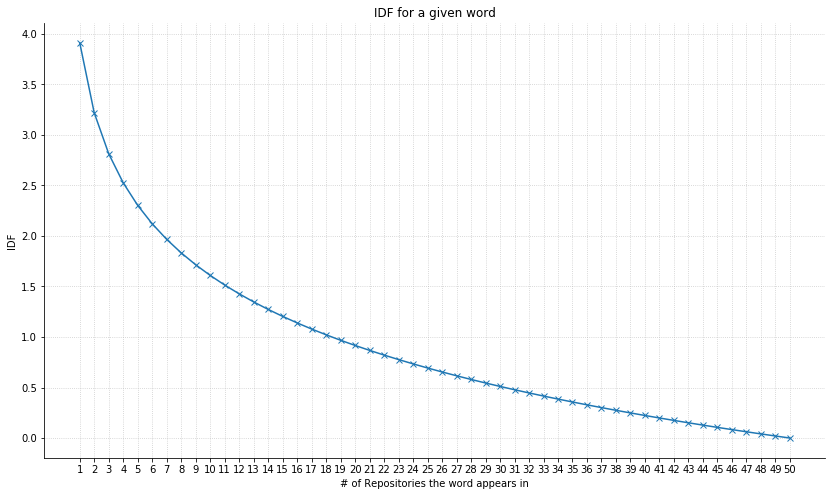

In [25]:
n_documents = 50

x_denominator = np.arange(1, n_documents + 1)
y_idf = np.log(n_documents / x_denominator)

plt.figure(figsize=(14, 8))
plt.plot(x_denominator, y_idf, marker='x')

plt.xticks(x_denominator)
plt.xlabel('# of Repositories the word appears in')
plt.ylabel('IDF')
plt.title('IDF for a given word')

In [26]:
def idf(word):
    n_occurrences = sum([1 for doc in df.cleaned if word in doc])
    n_docs = len(df.cleaned)
    idf = np.log(n_docs/n_occurrences)
    return idf

In [27]:
unique_words = pd.Series(' '.join(df.cleaned).split()).unique()

In [28]:
unique_words

array(['aidungeon', 'model', 'dungeon', ..., 'healthy', 'downstream',
       'schema'], dtype=object)

In [29]:
# put in a dataframe
idf_df = pd.DataFrame(dict(word = unique_words))\
    .assign(idf = lambda df: df.word.apply(idf))\
    .set_index('word').sort_values(by='idf', ascending = False)

idf_df.head(5)

,idf
word,
aidungeon,4.60517
prerelease,4.60517
rollout,4.60517
zoomin,4.60517
diligently,4.60517


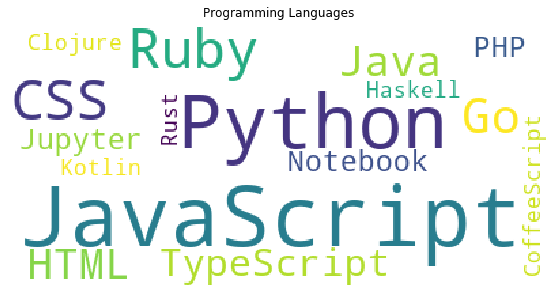

In [30]:
# Programming language value counts 
all_cloud = WordCloud(background_color='white').generate(' '.join(df.language))
plt.figure(figsize=(12, 5))
plt.imshow(all_cloud)
plt.title('Programming Languages')
plt.axis('off')
plt.show()

In [31]:
all_text = " ".join(df.cleaned)

In [32]:
all_words = prepare.clean(all_text)
all_words

['aidungeon',
 'model',
 'dungeon',
 'temporarily',
 'unavailable',
 'download',
 'due',
 'cost',
 'working',
 'solution',
 'read',
 'aidungeon',
 'wa',
 'built',
 'pcc',
 'byu',
 'edu',
 'dungeon',
 'creating',
 'infinitely',
 'generated',
 'text',
 'adventure',
 'deep',
 'learning',
 'language',
 'model',
 'play',
 'game',
 'colab',
 'aidungeon',
 'play',
 'game',
 'locally',
 'recommended',
 'nvidia',
 'gpu',
 'memory',
 'cuda',
 'installed',
 'gpu',
 'turn',
 'take',
 'couple',
 'minute',
 'game',
 'compose',
 'response',
 'install',
 'play',
 'locally',
 'git',
 'clone',
 'aidungeon',
 'aidungeon',
 'aidungeon',
 'install',
 'python',
 'play',
 'community',
 'aidungeon',
 'open',
 'source',
 'project',
 'question',
 'discussion',
 'contribution',
 'welcome',
 'contribution',
 'anything',
 'new',
 'package',
 'bugfixes',
 'documentation',
 'even',
 'new',
 'core',
 'feature',
 'resource',
 'website',
 'aidungeon',
 'aidungeon',
 'aidungeon',
 'twitter',
 'creator',
 'nickwalton',
 

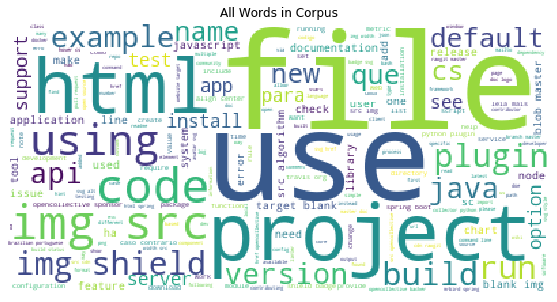

In [33]:
# Word cloud looking at all words in our corpus
img = WordCloud(background_color="white").generate(all_text)
plt.figure(figsize=(12, 5))
plt.imshow(img)
plt.axis("off")
plt.title('All Words in Corpus')
plt.show()

In [34]:
list(nltk.bigrams(all_text.split()))

[('aidungeon', 'model'),
 ('model', 'dungeon'),
 ('dungeon', 'temporarily'),
 ('temporarily', 'unavailable'),
 ('unavailable', 'download'),
 ('download', 'due'),
 ('due', 'cost'),
 ('cost', 'working'),
 ('working', 'solution'),
 ('solution', 'read'),
 ('read', 'aidungeon'),
 ('aidungeon', 'wa'),
 ('wa', 'built'),
 ('built', 'pcc'),
 ('pcc', 'byu'),
 ('byu', 'edu'),
 ('edu', 'dungeon'),
 ('dungeon', 'creating'),
 ('creating', 'infinitely'),
 ('infinitely', 'generated'),
 ('generated', 'text'),
 ('text', 'adventure'),
 ('adventure', 'deep'),
 ('deep', 'learning'),
 ('learning', 'language'),
 ('language', 'model'),
 ('model', 'play'),
 ('play', 'game'),
 ('game', 'colab'),
 ('colab', 'aidungeon'),
 ('aidungeon', 'play'),
 ('play', 'game'),
 ('game', 'locally'),
 ('locally', 'recommended'),
 ('recommended', 'nvidia'),
 ('nvidia', 'gpu'),
 ('gpu', 'memory'),
 ('memory', 'cuda'),
 ('cuda', 'installed'),
 ('installed', 'gpu'),
 ('gpu', 'turn'),
 ('turn', 'take'),
 ('take', 'couple'),
 ('coupl

In [35]:
list(nltk.ngrams(all_text.split(), 3))

[('aidungeon', 'model', 'dungeon'),
 ('model', 'dungeon', 'temporarily'),
 ('dungeon', 'temporarily', 'unavailable'),
 ('temporarily', 'unavailable', 'download'),
 ('unavailable', 'download', 'due'),
 ('download', 'due', 'cost'),
 ('due', 'cost', 'working'),
 ('cost', 'working', 'solution'),
 ('working', 'solution', 'read'),
 ('solution', 'read', 'aidungeon'),
 ('read', 'aidungeon', 'wa'),
 ('aidungeon', 'wa', 'built'),
 ('wa', 'built', 'pcc'),
 ('built', 'pcc', 'byu'),
 ('pcc', 'byu', 'edu'),
 ('byu', 'edu', 'dungeon'),
 ('edu', 'dungeon', 'creating'),
 ('dungeon', 'creating', 'infinitely'),
 ('creating', 'infinitely', 'generated'),
 ('infinitely', 'generated', 'text'),
 ('generated', 'text', 'adventure'),
 ('text', 'adventure', 'deep'),
 ('adventure', 'deep', 'learning'),
 ('deep', 'learning', 'language'),
 ('learning', 'language', 'model'),
 ('language', 'model', 'play'),
 ('model', 'play', 'game'),
 ('play', 'game', 'colab'),
 ('game', 'colab', 'aidungeon'),
 ('colab', 'aidungeon',

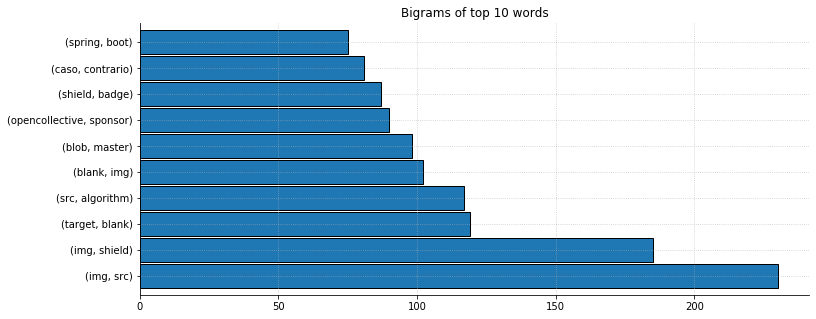

In [36]:
plt.figure(figsize=(12,5))
pd.Series(nltk.bigrams(all_words)).value_counts().head(10).plot.barh(width=.95)
plt.title('Bigrams of top 10 words')
plt.show()

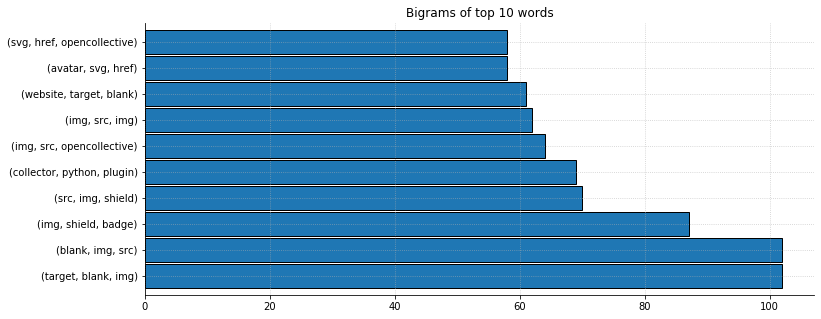

In [37]:
plt.figure(figsize=(12,5))
pd.Series(nltk.ngrams(all_words, 3)).value_counts().head(10).plot.barh(width=.95)
plt.title('Bigrams of top 10 words')
plt.show()

In [38]:
# plt.figure(figsize=(12,5))
# df.cleaned.plot.hist()
# plt.title('Frequency of Words')
# plt.show()

In [39]:
# A lot of bigrams are single letters or spaces
top_20_ham_bigrams = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams

(img, src)                   230
(img, shield)                185
(target, blank)              119
(src, algorithm)             117
(blank, img)                 102
(blob, master)                98
(opencollective, sponsor)     90
(shield, badge)               87
(caso, contrario)             81
(spring, boot)                75
(align, center)               74
(leia, mais)                  72
(travis, org)                 72
(avatar, svg)                 71
(src, img)                    71
(python, plugin)              71
(opencollective, backer)      71
(collector, python)           69
(command, line)               67
(brazilian, portuguese)       66
dtype: int64

In [40]:
# write a function to iterate and count each word in each repo

In [41]:
#df["readme_length"] = len(all_words)

In [42]:
df.head()

,language,original,normalized,stemmed,lemmatized,cleaned
0,Python,# AIDungeon2\n\n### The model for AI Dungeon2 ...,aidungeon the model for dungeon tempo...,aidungeon the model for dungeon temporarili un...,aidungeon the model for dungeon temporarily un...,aidungeon model dungeon temporarily unavailabl...
1,Go,"[<img src=""https://rclone.org/img/logo_on_ligh...",img src https rclone org img logo light h...,img src http rclone org img logo light horizon...,img src http rclone org img logo light horizon...,img src org img logo light horizontal color sv...
2,Python,# PythonPlantsVsZombies\na simple PlantsVsZomb...,pythonplantsvszombies simple plantsvszombies ...,pythonplantsvszombi simpl plantsvszombi game i...,pythonplantsvszombies simple plantsvszombies g...,pythonplantsvszombies simple plantsvszombies g...
3,Rust,"<img alt=""OrbTk"" width=""380"" src=""https://gitl...",img alt orbtk width src https gitla...,img alt orbtk width src http gitlab redox org ...,img alt orbtk width src http gitlab redox org ...,img alt width src gitlab redox org redox asset...
4,C,# UAC Bypass In The Wild\nWindows 10 UAC bypas...,uac bypass the wild windows uac bypass for...,uac bypass the wild window uac bypass for all ...,uac bypass the wild window uac bypass for all ...,uac bypass wild window uac bypass executable f...


### Model

In [43]:
# We want to look into the languages with only one appearance and remove those in order to run our models
df.language.value_counts()[df.language.value_counts() == 1]

Kotlin          1
Rust            1
CoffeeScript    1
Haskell         1
Clojure         1
C#              1
Name: language, dtype: int64

In [44]:
list(df.language.value_counts()[df.language.value_counts() == 1].index)

['Kotlin', 'Rust', 'CoffeeScript', 'Haskell', 'Clojure', 'C#']

In [45]:
df[df.language == 'Kotlin']
df = df.drop(20)
df[df.language == 'C#']
df = df.drop(21)
df[df.language == 'CoffeeScript']
df = df.drop(28)
df[df.language == 'Clojure']
df = df.drop(85)
df[df.language == 'Haskell']
df = df.drop(41)
df[df.language == 'Rust']
df = df.drop(3)

In [46]:
df = df.reset_index()

In [47]:
df.language.value_counts()

JavaScript          25
Python              20
Ruby                 9
CSS                  9
Go                   7
Java                 5
HTML                 5
C++                  4
TypeScript           4
Jupyter Notebook     2
PHP                  2
C                    2
Name: language, dtype: int64

#### *Logistic Regression*

In [48]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.cleaned)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

In [49]:
lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [50]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')

Accuracy: 26.32%
---
Confusion Matrix
actual      C  C++  CSS  Go  HTML  Java  JavaScript  Jupyter Notebook  PHP  \
predicted                                                                    
CSS         0    0    7   0     0     0           0                 0    0   
JavaScript  2    3    0   5     4     4          20                 2    2   
Python      0    0    0   0     0     0           0                 0    0   
Ruby        0    0    0   0     0     0           0                 0    0   

actual      Python  Ruby  TypeScript  
predicted                             
CSS              0     0           0  
JavaScript       0     6           3  
Python          16     0           0  
Ruby             0     1           0  
---


In [51]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---') 
print(classification_report(test.actual, test.predicted))

Accuracy: 26.32%
---
Confusion Matrix
actual      C++  CSS  Go  HTML  Java  JavaScript  Python  Ruby  TypeScript
predicted                                                                 
JavaScript    1    2   2     1     1           5       4     2           1
---
              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         1
         CSS       0.00      0.00      0.00         2
          Go       0.00      0.00      0.00         2
        HTML       0.00      0.00      0.00         1
        Java       0.00      0.00      0.00         1
  JavaScript       0.26      1.00      0.42         5
      Python       0.00      0.00      0.00         4
        Ruby       0.00      0.00      0.00         2
  TypeScript       0.00      0.00      0.00         1

    accuracy                           0.26        19
   macro avg       0.03      0.11      0.05        19
weighted avg       0.07      0.26      0.11        19



#### *Decision Tree*

In [52]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=123)

clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [53]:
print(clf.feature_importances_)

[0. 0. 0. ... 0. 0. 0.]


In [54]:
y_pred = clf.predict(X_train)
y_pred

array(['C', 'Python', 'Python', 'Python', 'Python', 'JavaScript',
       'Python', 'JavaScript', 'JavaScript', 'Python', 'Python',
       'JavaScript', 'Python', 'TypeScript', 'JavaScript', 'Python',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'Python', 'JavaScript', 'Python', 'Python', 'Python',
       'CSS', 'Python', 'JavaScript', 'JavaScript', 'Python',
       'JavaScript', 'C', 'Python', 'JavaScript', 'JavaScript', 'CSS',
       'JavaScript', 'Python', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'Python', 'TypeScript', 'Python',
       'Python', 'CSS', 'JavaScript', 'JavaScript', 'Python', 'CSS',
       'JavaScript', 'JavaScript', 'Python', 'Python', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'Python', 'JavaScript',
       'Python', 'Python', 'JavaScript', 'JavaScript', 'Python',
       'JavaScript', 'TypeScript', 'Python', 'Python', 'JavaScript',
       'CSS', 'Python'], dtype=object)

In [55]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba

array([[0.5       , 0.        , 0.        , 0.        , 0.        ,
        0.5       , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.15789474, 0.15789474,
        0.10526316, 0.        , 0.10526316, 0.10526316, 0.21052632,
        0.15789474, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.15789474, 0.15789474,
        0.10526316, 0.        , 0.10526316, 0.10526316, 0.21052632,
        0.15789474, 0.        ],
       [0.04545455, 0.13636364, 0.09090909, 0.09090909, 0.        ,
        0.04545455, 0.31818182, 0.        , 0.        , 0.04545455,
        0.18181818,

In [56]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.57


In [57]:
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.37


In [58]:
confusion_matrix(y_train, y_pred)

array([[ 1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0],
       [ 0,  0,  5,  0,  0,  0,  2,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  2,  0,  0,  3,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  1],
       [ 1,  0,  0,  0,  0,  0,  1,  0,  0,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 20,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0, 15,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  4,  0,  0,  3,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  2]])

#### *Random Forest*

In [59]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=10,
                            n_estimators=100,
                            max_depth=4, 
                            random_state=123)

In [60]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [61]:
print(rf.feature_importances_)

[0. 0. 0. ... 0. 0. 0.]


In [62]:
y_pred = rf.predict(X_train)
y_pred

array(['JavaScript', 'JavaScript', 'Python', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'Python', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'Python', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'Python', 'Python', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'Python', 'JavaScript',
       'JavaScript', 'JavaScript', 'Python', 'JavaScript', 'JavaScript',
       'JavaScript', 'Python', 'Python', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'Python', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript

In [63]:
y_pred_proba = rf.predict_proba(X_train)
y_pred_proba

array([[0.04871541, 0.04827352, 0.09430392, 0.06503529, 0.0629557 ,
        0.05585387, 0.24750656, 0.0225659 , 0.01972116, 0.18296132,
        0.1044003 , 0.04770706],
       [0.02735018, 0.03267391, 0.11011814, 0.06390645, 0.07540157,
        0.04453631, 0.24204871, 0.0328123 , 0.02042157, 0.21637802,
        0.08874509, 0.04560775],
       [0.02648627, 0.03348966, 0.07599926, 0.06402331, 0.04266778,
        0.05867554, 0.24666325, 0.03347979, 0.02672456, 0.27721392,
        0.07772614, 0.03685051],
       [0.02870824, 0.04095456, 0.08665316, 0.07733784, 0.05882561,
        0.04703215, 0.24912645, 0.02189406, 0.02752398, 0.22953502,
        0.09353786, 0.03887107],
       [0.02358232, 0.03445819, 0.0819664 , 0.06271971, 0.04361159,
        0.07800528, 0.27049103, 0.03228703, 0.03300849, 0.23534894,
        0.0770938 , 0.02742721],
       [0.03137967, 0.03377521, 0.08858815, 0.06981239, 0.04861816,
        0.0504134 , 0.2664357 , 0.0344993 , 0.02668091, 0.22840367,
        0.09023258,

In [64]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.40


In [65]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.26


In [66]:
print(confusion_matrix(y_train, y_pred))

[[ 0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  6  0  0 10  0  0]
 [ 0  0  0  0  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0  0  0  0]]


In [67]:
print(classification_report(y_train, y_pred))

                  precision    recall  f1-score   support

               C       0.00      0.00      0.00         2
             C++       0.00      0.00      0.00         3
             CSS       0.00      0.00      0.00         7
              Go       0.00      0.00      0.00         5
            HTML       0.00      0.00      0.00         4
            Java       0.00      0.00      0.00         4
      JavaScript       0.31      1.00      0.48        20
Jupyter Notebook       0.00      0.00      0.00         2
             PHP       0.00      0.00      0.00         2
          Python       0.91      0.62      0.74        16
            Ruby       0.00      0.00      0.00         7
      TypeScript       0.00      0.00      0.00         3

        accuracy                           0.40        75
       macro avg       0.10      0.14      0.10        75
    weighted avg       0.28      0.40      0.29        75



#### *K-Nearest Neighbors*

In [68]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [69]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [70]:
y_pred = knn.predict(X_train)
y_pred

array(['C', 'Ruby', 'Python', 'Python', 'Java', 'Go', 'Go', 'JavaScript',
       'Python', 'Java', 'Python', 'JavaScript', 'Java', 'Go',
       'JavaScript', 'C', 'JavaScript', 'JavaScript', 'Ruby',
       'JavaScript', 'JavaScript', 'Go', 'CSS', 'Java', 'HTML', 'Python',
       'CSS', 'JavaScript', 'CSS', 'C++', 'C++', 'C++', 'Go',
       'JavaScript', 'Python', 'Java', 'CSS', 'JavaScript', 'Java',
       'Ruby', 'Go', 'Ruby', 'JavaScript', 'CSS', 'Python', 'TypeScript',
       'Ruby', 'Python', 'CSS', 'JavaScript', 'JavaScript', 'Python',
       'CSS', 'JavaScript', 'JavaScript', 'Python', 'Python',
       'JavaScript', 'JavaScript', 'CSS', 'Go', 'Python', 'CSS', 'Python',
       'Ruby', 'JavaScript', 'CSS', 'Python', 'Ruby', 'JavaScript',
       'Python', 'CSS', 'JavaScript', 'CSS', 'Go'], dtype=object)

In [71]:
y_pred_proba = knn.predict_proba(X_train)
y_pred_proba

array([[0.2, 0. , 0. , 0.2, 0.2, 0. , 0.2, 0. , 0. , 0.2, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.2, 0. , 0.2, 0. , 0. , 0. , 0.6, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. ],
       [0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0.4, 0.4, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.4, 0. , 0. , 0.4, 0.2, 0. , 0. ],
       [0. , 0. , 0. , 0.2, 0. , 0. , 0.2, 0.2, 0.2, 0. , 0.2, 0. ],
       [0. , 0. , 0. , 0.4, 0. , 0.2, 0. , 0. , 0. , 0.2, 0.2, 0. ],
       [0. , 0.2, 0. , 0. , 0. , 0. , 0.4, 0. , 0.2, 0. , 0.2, 0. ],
       [0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0.4, 0.4, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.4, 0.4, 0. , 0.2, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0.8, 0. , 0. ],
       [0.2, 0. , 0. , 0. , 0. , 0. , 0.4, 0. , 0. , 0.2, 0.2, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.6, 0. , 0. , 0. , 0.4, 0. , 0. ],
       [0. , 0. , 0. , 0.2, 0.2, 0. , 0.2, 0. , 0.2, 0. , 0.2, 0. ],
       [0. , 0. , 0.4, 0. , 0. , 0

In [72]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.64


In [73]:
print(confusion_matrix(y_train, y_pred))

[[ 1  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  1  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  7  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  3  0  0  0  0  0  0  1  0]
 [ 1  0  1  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  1  0  3  0  0  0  0  0  0]
 [ 0  0  2  2  0  0 15  0  0  0  1  0]
 [ 0  0  0  0  1  0  1  0  0  0  0  0]
 [ 0  1  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  1  0  0 14  0  0]
 [ 0  0  1  1  0  1  0  0  0  1  3  0]
 [ 0  0  1  0  0  0  1  0  0  0  0  1]]


In [74]:
print(classification_report(y_train, y_pred))

                  precision    recall  f1-score   support

               C       0.50      0.50      0.50         2
             C++       0.33      0.33      0.33         3
             CSS       0.58      1.00      0.74         7
              Go       0.38      0.60      0.46         5
            HTML       0.00      0.00      0.00         4
            Java       0.50      0.75      0.60         4
      JavaScript       0.75      0.75      0.75        20
Jupyter Notebook       0.00      0.00      0.00         2
             PHP       0.00      0.00      0.00         2
          Python       0.93      0.88      0.90        16
            Ruby       0.43      0.43      0.43         7
      TypeScript       1.00      0.33      0.50         3

        accuracy                           0.64        75
       macro avg       0.45      0.46      0.43        75
    weighted avg       0.61      0.64      0.61        75



In [75]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of KNN classifier on test set: 0.26


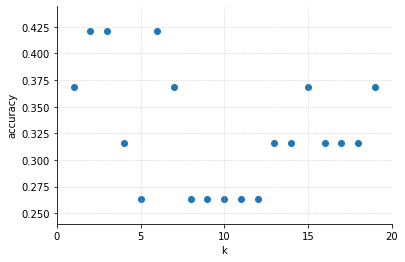

In [76]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])
plt.show()

In [77]:
rng = np.random.RandomState(1)
X = X_train
y = y_train

clf = BernoulliNB()
clf.fit(X, y)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [78]:
print(clf.predict(X))

['C' 'Python' 'Python' 'Python' 'Python' 'JavaScript' 'Python' 'Python'
 'Ruby' 'Python' 'Python' 'JavaScript' 'Python' 'JavaScript' 'JavaScript'
 'Python' 'JavaScript' 'JavaScript' 'Python' 'JavaScript' 'JavaScript'
 'Python' 'JavaScript' 'Python' 'Python' 'Python' 'Python' 'Python'
 'JavaScript' 'Python' 'Python' 'Python' 'Python' 'Python' 'Python'
 'JavaScript' 'Python' 'JavaScript' 'Python' 'Python' 'JavaScript'
 'Python' 'JavaScript' 'JavaScript' 'Python' 'JavaScript' 'Python'
 'Python' 'JavaScript' 'Jupyter Notebook' 'JavaScript' 'Python' 'Python'
 'JavaScript' 'JavaScript' 'Python' 'Python' 'JavaScript' 'JavaScript'
 'Python' 'Python' 'Python' 'JavaScript' 'Python' 'JavaScript'
 'JavaScript' 'JavaScript' 'Python' 'JavaScript' 'Python' 'Python'
 'Python' 'JavaScript' 'Python' 'JavaScript']


In [79]:
y_pred = clf.predict(X)
y_pred

array(['C', 'Python', 'Python', 'Python', 'Python', 'JavaScript',
       'Python', 'Python', 'Ruby', 'Python', 'Python', 'JavaScript',
       'Python', 'JavaScript', 'JavaScript', 'Python', 'JavaScript',
       'JavaScript', 'Python', 'JavaScript', 'JavaScript', 'Python',
       'JavaScript', 'Python', 'Python', 'Python', 'Python', 'Python',
       'JavaScript', 'Python', 'Python', 'Python', 'Python', 'Python',
       'Python', 'JavaScript', 'Python', 'JavaScript', 'Python', 'Python',
       'JavaScript', 'Python', 'JavaScript', 'JavaScript', 'Python',
       'JavaScript', 'Python', 'Python', 'JavaScript', 'Jupyter Notebook',
       'JavaScript', 'Python', 'Python', 'JavaScript', 'JavaScript',
       'Python', 'Python', 'JavaScript', 'JavaScript', 'Python', 'Python',
       'Python', 'JavaScript', 'Python', 'JavaScript', 'JavaScript',
       'JavaScript', 'Python', 'JavaScript', 'Python', 'Python', 'Python',
       'JavaScript', 'Python', 'JavaScript'], dtype='<U16')

In [80]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba

array([[1.00000000e+000, 6.35199053e-288, 3.53619740e-225,
        2.39751898e-227, 3.30537218e-236, 6.87861188e-258,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        2.88047950e-301, 1.07378733e-173, 2.04981409e-287],
       [0.00000000e+000, 0.00000000e+000, 1.28891934e-213,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        2.41781354e-007, 0.00000000e+000, 0.00000000e+000,
        9.99999758e-001, 8.73868548e-244, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 1.03027583e-243,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        1.41906581e-035, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000, 1.11563867e-268, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 4.52508137e-232,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        8.53804834e-047, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000, 6.75821979e-234, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 5.51270055

In [81]:
print('Accuracy of Naive Bayes classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Naive Bayes classifier on training set: 0.49


In [82]:
print(classification_report(y_train, y_pred))

                  precision    recall  f1-score   support

               C       1.00      0.50      0.67         2
             C++       0.00      0.00      0.00         3
             CSS       0.00      0.00      0.00         7
              Go       0.00      0.00      0.00         5
            HTML       0.00      0.00      0.00         4
            Java       0.00      0.00      0.00         4
      JavaScript       0.66      0.95      0.78        20
Jupyter Notebook       0.00      0.00      0.00         2
             PHP       0.00      0.00      0.00         2
          Python       0.37      1.00      0.54        16
            Ruby       1.00      0.14      0.25         7
      TypeScript       0.00      0.00      0.00         3

        accuracy                           0.49        75
       macro avg       0.25      0.22      0.19        75
    weighted avg       0.37      0.49      0.36        75



#### *Support Vector Machine (SVM)

In [83]:
X = X_train
y = y_train

clf = SVC(gamma='auto', kernel='linear')
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [84]:
clf.predict(X)

array(['C', 'HTML', 'Python', 'Python', 'Java', 'JavaScript', 'Go', 'C++',
       'Ruby', 'JavaScript', 'Python', 'JavaScript', 'Java', 'HTML',
       'JavaScript', 'HTML', 'JavaScript', 'JavaScript', 'Ruby',
       'JavaScript', 'JavaScript', 'Ruby', 'Ruby', 'JavaScript',
       'Jupyter Notebook', 'Python', 'CSS', 'JavaScript', 'JavaScript',
       'C++', 'PHP', 'Go', 'Java', 'Python', 'Python', 'Java', 'CSS',
       'C++', 'Python', 'C', 'JavaScript', 'Ruby', 'JavaScript', 'CSS',
       'Python', 'TypeScript', 'Go', 'Python', 'CSS', 'JavaScript',
       'JavaScript', 'Python', 'CSS', 'JavaScript', 'JavaScript',
       'Python', 'Python', 'JavaScript', 'JavaScript', 'CSS', 'Go',
       'Python', 'JavaScript', 'Python', 'Ruby', 'JavaScript',
       'TypeScript', 'Python', 'JavaScript', 'TypeScript', 'Python',
       'HTML', 'JavaScript', 'CSS', 'Go'], dtype=object)

In [85]:
print('Accuracy of Stochastic SVM on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Stochastic SVM on training set: 0.96


In [86]:
print('Accuracy of Stochastic SVM on training set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Stochastic SVM on training set: 0.26


#### *Stochastic Gradient Descent* 

In [87]:
X = X_train
y = y_train
# clf = linear_model.SGDClassifier(max_iter=, tol=1e-3)
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
clf.fit(X, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [88]:
clf.predict(X)

array(['C', 'HTML', 'Python', 'Python', 'Java', 'JavaScript', 'Go', 'C++',
       'Ruby', 'PHP', 'Python', 'JavaScript', 'Java', 'HTML',
       'JavaScript', 'HTML', 'JavaScript', 'JavaScript', 'Ruby',
       'JavaScript', 'JavaScript', 'Ruby', 'Ruby', 'Ruby',
       'Jupyter Notebook', 'Python', 'CSS', 'Jupyter Notebook',
       'JavaScript', 'C++', 'PHP', 'Go', 'Java', 'Python', 'Python',
       'Java', 'CSS', 'C++', 'Python', 'C', 'JavaScript', 'Ruby',
       'JavaScript', 'CSS', 'Python', 'TypeScript', 'Go', 'Python', 'CSS',
       'JavaScript', 'JavaScript', 'Python', 'CSS', 'JavaScript',
       'JavaScript', 'Python', 'Python', 'JavaScript', 'JavaScript',
       'CSS', 'Go', 'Python', 'JavaScript', 'Python', 'Ruby',
       'JavaScript', 'TypeScript', 'Python', 'JavaScript', 'TypeScript',
       'Python', 'HTML', 'JavaScript', 'CSS', 'Go'], dtype='<U16')

In [89]:
print('Accuracy of Stochastic Gradient Decent Classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Stochastic Gradient Decent Classifier on training set: 1.00


In [90]:
print(classification_report(y_train, y_pred))

                  precision    recall  f1-score   support

               C       1.00      0.50      0.67         2
             C++       0.00      0.00      0.00         3
             CSS       0.00      0.00      0.00         7
              Go       0.00      0.00      0.00         5
            HTML       0.00      0.00      0.00         4
            Java       0.00      0.00      0.00         4
      JavaScript       0.66      0.95      0.78        20
Jupyter Notebook       0.00      0.00      0.00         2
             PHP       0.00      0.00      0.00         2
          Python       0.37      1.00      0.54        16
            Ruby       1.00      0.14      0.25         7
      TypeScript       0.00      0.00      0.00         3

        accuracy                           0.49        75
       macro avg       0.25      0.22      0.19        75
    weighted avg       0.37      0.49      0.36        75



In [91]:
print('Accuracy of Stochastic Gradient Decent classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of Stochastic Gradient Decent classifier on test set: 0.37


#### *AdaBoost*

In [92]:
X = X_train
y = y_train
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

In [93]:
print(clf.feature_importances_)

[0. 0. 0. ... 0. 0. 0.]


In [94]:
clf.predict(X)

array(['C', 'JavaScript', 'Python', 'Python', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'PHP', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'Python', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'PHP', 'JavaScript', 'Python',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript', 'Python', 'C', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'Python', 'JavaScript', 'JavaScript',
       'JavaScript', 'JavaScript', 'JavaScript', 'Python', 'Python',
       'JavaScript', 'JavaScript', 'JavaScript', 'Python', 'Python',
       'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript', 'Python',
       'JavaScript', 'Python', 'JavaScript', 'JavaScript', 'JavaScript',
       'Python', 'JavaScript', 'JavaScript',

In [95]:
clf.score(X, y)

0.4533333333333333

#### *Bagging*

In [96]:
X = X_train
y = y_train

clf = BaggingClassifier(n_estimators=3, random_state=0)
clf.fit(X, y)
clf.predict(X)

array(['C', 'HTML', 'Python', 'Python', 'Java', 'JavaScript', 'Go', 'C++',
       'Ruby', 'PHP', 'Python', 'JavaScript', 'Python', 'HTML',
       'JavaScript', 'HTML', 'JavaScript', 'JavaScript', 'C++',
       'JavaScript', 'JavaScript', 'Ruby', 'Ruby', 'Ruby', 'Python',
       'Python', 'CSS', 'Jupyter Notebook', 'JavaScript', 'C++', 'PHP',
       'Go', 'Java', 'Python', 'Python', 'JavaScript', 'CSS', 'C++',
       'Python', 'C', 'JavaScript', 'Ruby', 'JavaScript', 'CSS', 'Python',
       'TypeScript', 'Go', 'Python', 'CSS', 'JavaScript', 'JavaScript',
       'CSS', 'JavaScript', 'JavaScript', 'JavaScript', 'Python',
       'Python', 'JavaScript', 'JavaScript', 'CSS', 'Go', 'Python',
       'JavaScript', 'Python', 'Ruby', 'JavaScript', 'TypeScript',
       'Python', 'JavaScript', 'TypeScript', 'Python', 'HTML',
       'JavaScript', 'CSS', 'Go'], dtype=object)

In [97]:
print('Accuracy of Bagging classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Bagging classifier on training set: 0.92


In [98]:
clf.score(X_test, y_test)

0.3684210526315789